Face Expression Recognizer: Use Cases- Market Research, Gaming Industry, Behaviour Testing  
Emotions: seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)  


## Import Data and Dependencies

In [ ]:
!nvidia-smi

In [ ]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2021-07-27 09:10:12--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2021-07-27 09:10:12--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc368da10d540935356c561493e6.dl.dropboxusercontent.com/cd/0/inline/BTGsiedNOH79WJsBX5vpZuLbAfo7zFprUTH1yoNmn6V6iH5s05vxstzDZGP0j5iqY5w2P-ffdMV2DCmri7hFtSL3E9NYpkfkbdlLt2UGvSvDai-5NWqGuKDkjD8MjF-Y3xH7Fd3tpbp7n_KkslU-Rfhl/file# [following]
--2021-07-27 09:10:12--  https://uc368da10d540935356c561493e6.dl.dropboxusercontent.com/cd/0/inline/BTGsiedNOH79WJsBX5vpZuLbAfo7zFprUTH1yoNmn6V6iH5s05vxstzDZGP0j5iqY5w2P-ffdMV2DCmri7hFtSL3E9NYp

In [ ]:
!unzip -q "/content/archive.zip"

In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [ ]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/sad/Training_86170826.jpg',
 '/content/train/sad/Training_7269195.jpg',
 '/content/train/sad/Training_75293540.jpg',
 '/content/train/sad/Training_89001863.jpg',
 '/content/train/sad/Training_59719745.jpg',
 '/content/train/sad/Training_25039953.jpg',
 '/content/train/sad/Training_54228372.jpg',
 '/content/train/sad/Training_81039583.jpg',
 '/content/train/sad/Training_42815150.jpg',
 '/content/train/sad/Training_34732469.jpg']

In [ ]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad']

In [ ]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split 

X_train , X_val , y_train , y_val = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
# Compute class weights 

classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8133111, 1: 16.663609, 2: 1.7801372, 3: 1.0, 4: 1.4596839, 5: 1.5148735, 6: 2.3098772}


## Data Loading and Augmentation

In [ ]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    # convert paths and labels to tensor
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    # create dataset objects for images and labels
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    # zip them to be able to iterate on both at once
    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    # apply load and resize on dataset
    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)

    # shuffle and batch the dataset
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    # if train = True apply data augmentation
    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    # if not training repeat over the dataset and return
    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(X_train , y_train)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 327 ms, sys: 10.2 ms, total: 337 ms
Wall time: 393 ms
(32, 96, 96, 3)
(32, 7)


happy


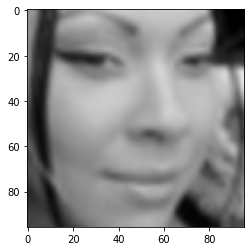

In [ ]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(X_val , y_val , train=False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 26.7 ms
(32, 96, 96, 3)
(32, 7)


neutral


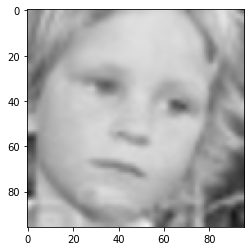

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

## Model Training

In [ ]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False  # not including a final layers of EfficientNetB2
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 7,949,824
Trainable params: 7,882,249
Non-trainable params: 67,575
_________________________________________________________________


In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(X_val)//BATCH_SIZE,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12
672/672 [==============================] - 141s 145ms/step - loss: 2.8878 - accuracy: 0.3900 - precision: 0.6411 - recall: 0.1699 - val_loss: 1.3005 - val_accuracy: 0.5042 - val_precision: 0.7203 - val_recall: 0.2921
Epoch 2/12
672/672 [==============================] - 96s 141ms/step - loss: 2.3747 - accuracy: 0.4963 - precision: 0.6876 - recall: 0.2888 - val_loss: 1.2034 - val_accuracy: 0.5518 - val_precision: 0.7160 - val_recall: 0.3655
Epoch 3/12
672/672 [==============================] - 97s 144ms/step - loss: 2.2305 - accuracy: 0.5274 - precision: 0.7007 - recall: 0.3304 - val_loss: 1.2440 - val_accuracy: 0.5310 - val_precision: 0.6713 - val_recall: 0.3682
Epoch 4/12
672/672 [==============================] - 96s 143ms/step - loss: 2.0914 - accuracy: 0.5508 - precision: 0.7181 - recall: 0.3658 - val_loss: 1.2825 - val_accuracy: 0.526

In [ ]:
# we expect our model to just learn patterns in current data.
# then we freeze all the layers and train only on last layer where we do classification, 
# this gives more importance to the classification layer, thus making it more accurate

In [ ]:
# turnoff the backbone after tuning weights - to ensure the lesser chance of overfitting
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only = True)

early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(X_val)//BATCH_SIZE,
    class_weight=class_weight
)

## Evaluating the model

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")